To do
* Sort out testing and validation
* Actually validate the ensemble

## Neural net with FastAI API

In the Kaggle competitions neural nets have fallen out of vogue; the decision tree classifiers and gradient boosting machine-type models reign supreme. Neural nets still perform pretty well and there are use cases where they may be superior, as per [FastBook](https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb):
* When the dataset contains **important high cardinality variables**, e.g. Zip codes
* There are columns which contain data like pictures and plain text that **would be better undestood by a neural net**

In practice, you can just try both and see what works best. If it's a large dataset, use subsets to get an idea of performance.

These models were trained on a NVidia RTX 3060 GPU my desktop computer.

# Setup

In [19]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
# from fastai.imports import *
from fastai.tabular.all import *
import torch
from sklearn.model_selection import train_test_split
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    !pip install -Uqq fastai
    path = Path('/kaggle/input/playground-series-s4e3')
else:
    import zipfile,kaggle
    path = Path('playground-series-s4e3')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

playground-series-s4e3.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
target_classes = ["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]
targets_df = train_df[target_classes]
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(target_classes + ['id'], axis=1), 
                                                    targets_df, test_size=0.1, random_state=40)

categorical = ['TypeOfSteel_A300', 'TypeOfSteel_A400', 'Outside_Global_Index']
numerical = list(set(train_df.columns) - set(categorical) - set(target_classes))
numerical.remove('id')

# Baseline model

Note here that we are using random splitting of the training and validation sets. This would optimally be done using stratified splitting, but I havent implemented this yet.
Can look at [this post on the FastAI forums](https://forums.fast.ai/t/stratified-labels-sampling/28002/5) or [this one on Stack Overflow](https://stackoverflow.com/questions/57781005/how-to-implement-sklearns-stratifiedkfold-with-fastai)  where the idea was implemented on vision learning models. Basically you need to split your datasets before feeding it into the TabularPandas

In [15]:
%%time
# What did I do here?
splits = RandomSplitter(valid_pct=0.2)(range_of(X_train))
# splits = RandomSplitter(valid_pct=0.2)

y_block = MultiCategoryBlock()
procs = [Categorify, Normalize] #We can add "FillMissing" here if we have missing data

to = TabularPandas(train_df, procs=procs, cat_names=categorical, cont_names=numerical, splits=splits, y_names=target_classes)
dls = to.dataloaders(bs=1028)

learn = tabular_learner(dls, metrics=[accuracy_multi,RocAucMulti()], loss_func = BCEWithLogitsLossFlat())
learn.fit(10)

epoch,train_loss,valid_loss,accuracy_multi,roc_auc_score,time
0,0.655364,0.644689,0.662702,0.821435,00:00
1,0.629241,0.605866,0.738281,0.837077,00:00
2,0.609702,0.570980,0.782926,0.837272,00:00
3,0.588966,0.529345,0.822079,0.841321,00:00
4,0.563932,0.483660,0.851030,0.843187,00:00
5,0.533573,0.435637,0.869492,0.844971,00:00
6,0.499319,0.388055,0.879651,0.845583,00:00
7,0.463114,0.343236,0.885805,0.844310,00:00
8,0.427662,0.316356,0.886838,0.849712,00:00
9,0.394773,0.290422,0.889605,0.852635,00:00


CPU times: user 1.96 s, sys: 300 ms, total: 2.26 s
Wall time: 2.23 s


Here we get a baseline AUC score of 0.852635 using the factory settings, without optmising the learning rate, 10 epochs. The model is able to do this in 2.23 seconds training on a RTX3060 GPU

SuggestedLRs(valley=0.0006918309954926372, slide=0.02290867641568184)

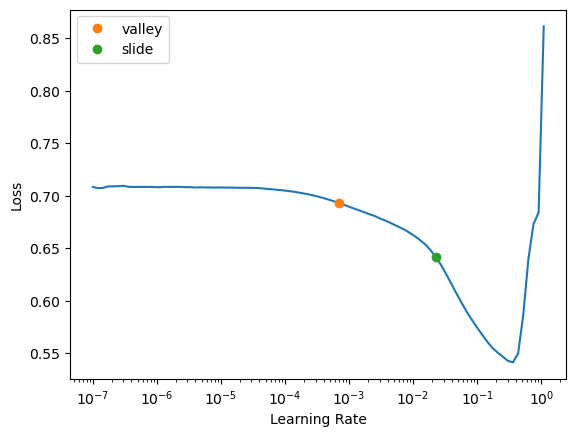

In [31]:
learn = tabular_learner(dls, metrics=[accuracy_multi,RocAucMulti()], loss_func = BCEWithLogitsLossFlat())
learn.lr_find(suggest_funcs=(valley, slide))

Now we'll check the results using an optimised learning rate between the valley and the slide:

In [32]:
%%time
learn.fit(25, lr = 1e-2)

epoch,train_loss,valid_loss,accuracy_multi,roc_auc_score,time
0,0.541482,0.397575,0.887375,0.821214,00:00
1,0.396776,0.246770,0.887870,0.854674,00:00
2,0.328492,0.240668,0.888201,0.862637,00:00
3,0.293855,0.238282,0.889894,0.864233,00:00
4,0.273211,0.235499,0.890389,0.867228,00:00
5,0.259508,0.233789,0.890018,0.869026,00:00
6,0.250071,0.233359,0.890885,0.869186,00:00
7,0.243148,0.234926,0.890266,0.867785,00:00
8,0.237621,0.233721,0.890389,0.869477,00:00
9,0.233252,0.233950,0.888820,0.870031,00:00


CPU times: user 5.2 s, sys: 614 ms, total: 5.82 s
Wall time: 5.73 s


AUC has improved to 0.868517. Now we'll see what happens with further optimised hyperparameters. We've increased the number of epochs, but added early stopping and also added a callback to reduce the learning rate on plateau.

In [27]:
learner = tabular_learner(dls, layers = [64, 32], metrics=[accuracy_multi,RocAucMulti()], loss_func = BCEWithLogitsLossFlat(),
                          cbs=[ReduceLROnPlateau(monitor='valid_loss', min_delta=0.5, patience=5), 
                               EarlyStoppingCallback(monitor='valid_loss', min_delta=0, patience=5)]) 
learner.fit(50, lr = 1e-2)

epoch,train_loss,valid_loss,accuracy_multi,roc_auc_score,time
0,0.597134,0.506687,0.871639,0.826319,00:00
1,0.474886,0.291529,0.888820,0.847716,00:00
2,0.381282,0.243956,0.887251,0.853492,00:00
3,0.329581,0.237758,0.889935,0.860886,00:00
4,0.298347,0.236047,0.890389,0.864870,00:00
5,0.278133,0.237864,0.888655,0.864147,00:00
6,0.263980,0.234253,0.890266,0.866070,00:00
7,0.253977,0.233184,0.890637,0.867610,00:00
8,0.246510,0.233088,0.890968,0.868035,00:00
9,0.240921,0.232960,0.891216,0.867964,00:00


Epoch 5: reducing lr to 0.001
Epoch 10: reducing lr to 0.0001
Epoch 15: reducing lr to 1e-05
Epoch 20: reducing lr to 1.0000000000000002e-06
No improvement since epoch 16: early stopping


## *Using CPU (not currently working

In [20]:
%%time
torch.set_default_device('cpu')
learn.to('cpu')  # Ensure the learner uses the CPU
learn.fit(10)

epoch,train_loss,valid_loss,accuracy_multi,roc_auc_score,time
0,0.220280,0.240417,0.887788,0.856762,00:00
1,0.219498,0.239199,0.888242,0.858451,00:00
2,0.218457,0.239009,0.887622,0.860932,00:00
3,0.217509,0.239938,0.888531,0.859717,00:00
4,0.216438,0.240121,0.887003,0.859348,00:00
5,0.215646,0.240555,0.886342,0.858391,00:00
6,0.214572,0.239900,0.887416,0.859126,00:00
7,0.213554,0.241600,0.885557,0.855551,00:00
8,0.212489,0.240160,0.887127,0.860181,00:00
9,0.211469,0.240409,0.885764,0.858623,00:00


CPU times: user 2.31 s, sys: 158 ms, total: 2.47 s
Wall time: 2.44 s


In [21]:
device = next(learn.model.parameters()).device
print(f'The model is using: {device}')

The model is using: cuda:0


# Adding ensembling

Ensembling is a technique where you train multiple models and average out their predictions. We hope to get improved accuracy as the models may learn slightly different characteristics about the dataset.

In [33]:
def ensemble(dls, learner_cnt):    
    learners = list()
    for _ in range(learner_cnt):
        print(f"Learner {_} started training.")
        learn = tabular_learner(dls, metrics=[accuracy_multi], loss_func = BCEWithLogitsLossFlat(),
                                cbs=[ReduceLROnPlateau(monitor='valid_loss', min_delta=0.5, patience=5), # for reducing learning rate
                                     EarlyStoppingCallback(monitor='valid_loss', min_delta=0, patience=5)]) # for early stopping training
        with learn.no_bar(), learn.no_logging():
            learn.fit(40, lr = 1e-2)
            
        learners.append(learn)
        print(f"Learner {_} trained.")
    return learners

In [34]:
%%time
learners = ensemble(dls, 10)

Learner 0 started training.
Epoch 5: reducing lr to 0.001
Epoch 10: reducing lr to 0.0001
Epoch 15: reducing lr to 1e-05
No improvement since epoch 14: early stopping
Learner 0 trained.
Learner 1 started training.
Epoch 5: reducing lr to 0.001
Epoch 10: reducing lr to 0.0001
No improvement since epoch 7: early stopping
Learner 1 trained.
Learner 2 started training.
Epoch 5: reducing lr to 0.001
Epoch 10: reducing lr to 0.0001
No improvement since epoch 9: early stopping
Learner 2 trained.
Learner 3 started training.
Epoch 5: reducing lr to 0.001
Epoch 10: reducing lr to 0.0001
No improvement since epoch 6: early stopping
Learner 3 trained.
Learner 4 started training.
Epoch 5: reducing lr to 0.001
Epoch 10: reducing lr to 0.0001
No improvement since epoch 8: early stopping
Learner 4 trained.
Learner 5 started training.
Epoch 5: reducing lr to 0.001
Epoch 10: reducing lr to 0.0001
Epoch 15: reducing lr to 1e-05
No improvement since epoch 13: early stopping
Learner 5 trained.
Learner 6 st